<a href="https://colab.research.google.com/github/javadch/covid19/blob/master/Covid19_Cases_Germany.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is a try to understand the behavior of the Coronavirus in Germany using data.
The data is obtained from [ECDC](https://www.ecdc.europa.eu) which is free, open, and contains worldwide cumulative counts for new confirmed, deaths, and recovered cases. It may have missing values, especially in the recovered cases, which I did not try to improve.
In this study, China has been used as a baseline to be able to compare German data and be able to make sense of the situation.
You can find information about the author [here](https://www.tib.eu/en/research-development/data-science-digital-libraries/staff/javad-chamanara/).

In [0]:
# Use of the EUDAT data
import datetime as dt
import pandas as pd
import requests
import io
import math
import matplotlib.pyplot as plt

nowUtc = dt.datetime.utcnow()
url_pattern = 'https://www.ecdc.europa.eu/sites/default/files/documents/COVID-19-geographic-disbtribution-worldwide-YYYY-MM-DD.xlsx'
# It is possible that ECDC has not yet uploaded the today's data.
# In this case, I fallback to yesterday's dataset
try:
  url = url_pattern.replace('YYYY', '{:04d}'.format(nowUtc.year)).replace('MM', '{:02d}'.format(nowUtc.month)).replace('DD', '{:02d}'.format(nowUtc.day))
  #print(url) 
  data = pd.read_excel(url, index_col=0) 
except: # fallback to yesterday
  nowUtc = nowUtc- dt.timedelta(days=1)
  url = url_pattern.replace('YYYY', '{:04d}'.format(nowUtc.year)).replace('MM', '{:02d}'.format(nowUtc.month)).replace('DD', '{:02d}'.format(nowUtc.day))
  #print(url) 
  data = pd.read_excel(url, index_col=0) 


In [24]:
germany = data[(data['GeoId'] == "DE")].sort_values(by=['DateRep'], ascending=True)
china   = data[(data['GeoId'] == "CN")].sort_values(by=['DateRep'], ascending=True)
print(germany.tail(3))

            Day  Month  Year  Cases  Deaths Countries and territories GeoId
DateRep                                                                    
2020-03-17   17      3  2020   1174       1                   Germany    DE
2020-03-18   18      3  2020   1144       0                   Germany    DE
2020-03-19   19      3  2020   1042       0                   Germany    DE


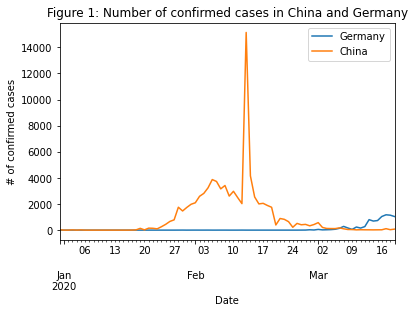

In [25]:
germany['Cases'].plot(legend = True, label = 'Germany')
china['Cases'].plot(legend = True, label = 'China')
plt.xlabel('Date')
plt.ylabel('# of confirmed cases')
plt.title("Figure 1: Number of confirmed cases in China and Germany")
plt.legend()
plt.show()

The figure above shows that China is flattening the curve, while Germany if facing its exponential spreading phase. In order to zoom over that surging timespan, we draw the chart for Germany only in the following code block. With an exception on March the 9th (which is still not clear what has happened there), the chart indicates a clear exponential behavior starting from 28.01.2020.

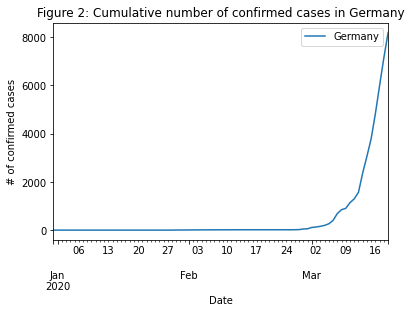

The first recorded incident in China: DatetimeIndex(['2019-12-31'], dtype='datetime64[ns]', name='DateRep', freq=None)
The first recorded incident in Germany: DatetimeIndex(['2020-01-28'], dtype='datetime64[ns]', name='DateRep', freq=None)


In [26]:
germany['Cases'].cumsum().plot(label = 'Germany')
plt.xlabel('Date')
plt.ylabel('# of confirmed cases')
plt.title("Figure 2: Cumulative number of confirmed cases in Germany")
plt.legend()
plt.show()
# The date of the first recorded incident in China
print('The first recorded incident in China:', china[(china['Cases']>0)].head(1).index)
# The date of the first recorded incident in Germany
print('The first recorded incident in Germany:', germany[(germany['Cases']>0)].head(1).index)

One interesting observation here is that the first positive records in China and Germany where on 31.12.2019 and 28.01.2020 respectively, indicating 28 days shift. This implies that Germany has been able to keep itself safe from the virus for 4 weeks. 

However, afterwards, the virus has spread very quickly! It means that the seed spreading should have happened in a highly-populated area or in an event with remarkable close contacts between a large number of people.

Another important point to study is that the spreading speed in Germany is exponential but in the case of China (except for that middle pick) the slope looks like a linear or a mild polynomial one. Should this be interpreted as the results of policies and actions implemented in China?

However, a good fact about Corona in Germany is that the number of deaths is outstandingly low and almost constant (even better than linear).

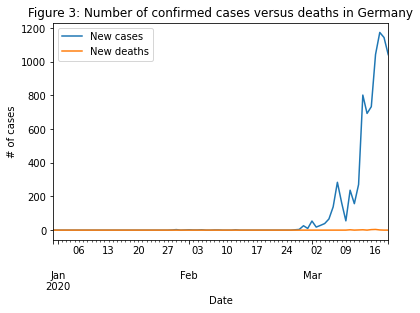

In [27]:
germany['Cases'].plot(label = 'New cases')
germany['Deaths'].plot(label = 'New deaths')
plt.xlabel('Date')
plt.ylabel('# of cases')
plt.title("Figure 3: Number of confirmed cases versus deaths in Germany")
plt.legend()
plt.show()

To see the trend of death cases better, in the following code block I draw it without the other charts. The charts shows daily new and cumulative incidents.

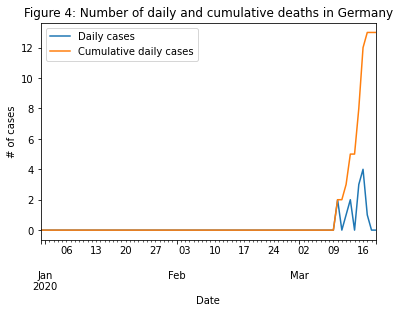

In [28]:
germany['Deaths'].plot(label = 'Daily cases')
germany['Deaths'].cumsum().plot(label = 'Cumulative daily cases')
plt.xlabel('Date')
plt.ylabel('# of cases')
plt.title("Figure 4: Number of daily and cumulative deaths in Germany")
plt.legend()
plt.show()

And if we calculate and draw the fatality rate, we can see this even better. The fatality rate is the percentage of people who contract the coronavirus and then die. To calculate the ratio, we have two models:
1. $Deaths/TotalCases$: This model is likely to be an underestimate because lots of open cases can still end up in death.
2. $Deaths/ClosedCases$: Closed cases is the sum of death and recovered cases. This model is an overestimate because it’s likely that deaths are closed quicker than recoveries. 

Model 1 will show a lower rate in the beginning and increases when the epidemy is getting contained. Model 2 behaves the other way round. Therefore, it would be good to calculate and draw both of them and observe how they converge over time.

**Unfortunately**, the current dataset does not provide the recovered cases. So, I am relying on model 1.

Mean fataility rate: 0.07091597070382197 %


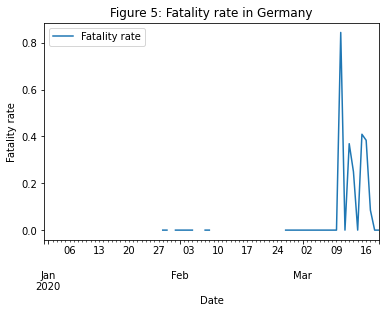

In [29]:
germany['FatalityRate'] = 100*germany['Deaths']/germany['Cases']
#print(germany['FatalityRate'])
print('Mean fataility rate:', germany['FatalityRate'].mean(), '%')
germany['FatalityRate'].plot(label = 'Fatality rate')
plt.xlabel('Date')
plt.ylabel('Fatality rate')
plt.title("Figure 5: Fatality rate in Germany")
plt.legend()
plt.show()
death_days_germany = germany[germany['Deaths'] > 0].count()['Deaths'] # number of days with death records
death_germany = germany['Deaths'].sum() # total number of deaths recorded

The fatality rate is well bellow 1% which is much better than that of China.
Also, there were only 4 days with death records with a total casualty of 8 so far (15.03). This is on average one death per 10 million; very promising.
However, as the epidemic has already entered its exponential phase, expecting higher fatality should not be surprising, as the indicators are appearing. See the following diagram that shows the death chart is also entring its exponential phase!

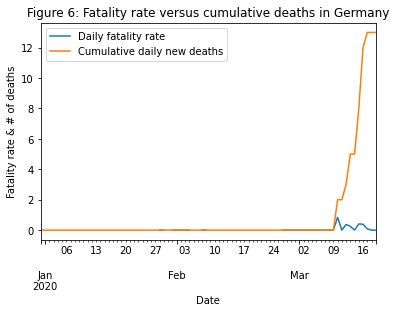

In [30]:
germany['FatalityRate'].plot(label = 'Daily fatality rate')
germany['Deaths'].cumsum().plot(label = 'Cumulative daily new deaths')
plt.xlabel('Date')
plt.ylabel('Fatality rate & # of deaths')
plt.title("Figure 6: Fatality rate versus cumulative deaths in Germany")
plt.legend()
plt.show()

# Recorded cases versus real cases
Probably you have noticed that I am referring to `recorded` cases instead of simply saying cases. This is because in biological epidemics there is a time lag between getting affected and being identified.
The data source used in this study has only collected the date that the cases were identified. This implies that the report is behind the virus movement, bot how long?

According to [sources](https://github.com/midas-network/COVID-19/tree/master/parameter_estimates/2019_novel_coronavirus), the virus enjoys a 5 day incubation time $(it)$. After this time, if the patient receives medical aid, gets diagnosed, tested, and registered, it takes, on average, 3 more days $(tt)$ to identify whether the person was a case. 
It is realistic to assume that people do not (or can not) seek medial assistance right after the incubation time, so I consider `time from symptom onset to reporting` $(nt)$ of [5](https://doi.org/10.1101/2020.01.29.20019547) days. However, as public awareness and govermenemtn readiness are developing, this parameter should be decreasing. So, I reduce it to 3 days. Putting them together, the timeline from infection to registration would be $rt = it+nt+tt$. 
$||-----(it)-----|--(nt)--|---(tt)---||$

This timeline indicates that what is recorded today has happened $rt$ days ago, which is 11 days in this model. 
If we could have tested and registered all the cases, could we claim that the `real` number of affected people 11 days ago is the number of registered cases today; a very hard question to answer!

However, the more important question is that if we know the number of recorded cases today, what would be our estimation of the number of real cases for today (or tomorrow!).

There is a model that can do the job based on the numbers of recorded deaths $(dbe)$. 
It is a reliable model as it utilizes the number of death cases which is certainly known per day with high accuracy.

# The Death-Based Estimatin method $(dbe)$
In order to estimate $dbe$ we need the following parameters:
1. The time from symptom onset to death is on average [17.3](https://github.com/midas-network/COVID-19/tree/master/parameter_estimates/2019_novel_coronavirus#time-from-symptom-onset-to-death) days. Adding the incubation time $lt$ of 5 days results in 22.3 days from infection to death $(lt)$.
2. Avergae doubling time $dt$ is [2.73](https://github.com/midas-network/COVID-19/tree/master/parameter_estimates/2019_novel_coronavirus#doubling-time). This is the average number of days that the cases get doubled.
3. Fatality rate in Germany as shown above, is currently bellow 1%. For simplicity I round it up to 1%.

I use this formula to estimate the number of real cases for a given day $d_n$:

$rc_n = (dc_n / mfr)*2^{(lt/dt)}$

In the formula we have:
- $dc_n$: death cases reported in $d_n$
- $mfr$: mean fataility rate
- $rc_n$: the number of real cases in $d_n$

DateRep
2020-03-15     86314.592189
2020-03-16    115086.122919
2020-03-17     28771.530730
2020-03-18         0.000000
2020-03-19         0.000000
Name: RealCases, dtype: float64


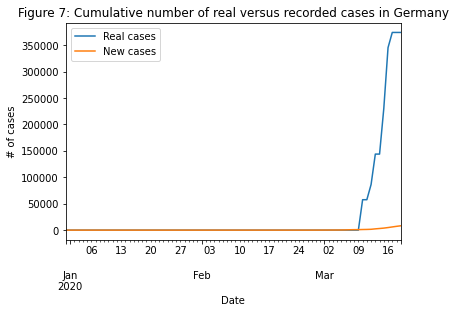

Max and min number of real cases: 115086.12291902852 0.0


In [31]:
# estimation of the number of real cases, using dbe
mfr = 0.01
lt = 22.3
dt = 2.73
germany['RealCases'] = (germany['Deaths']/mfr)*pow(2, (lt/dt))
print(germany['RealCases'].tail(5))
germany['RealCases'].cumsum().plot(label = 'Real cases')
germany['Cases'].cumsum().plot(label = 'New cases')
plt.xlabel('Date')
plt.ylabel('# of cases')
plt.title("Figure 7: Cumulative number of real versus recorded cases in Germany")
plt.legend()
plt.show()
print('Max and min number of real cases:', germany['RealCases'].max(), germany['RealCases'].min())

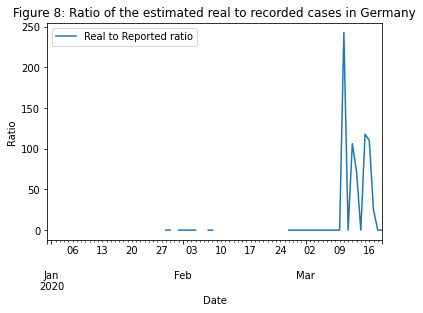

Average, max, min of real cases versus recorded cases: 20.403610303355702 242.79772767727536 0.0


In [32]:
ratio = germany['RealCases']/germany['Cases']
ratio.plot(label = 'Real to Reported ratio')
plt.xlabel('Date')
plt.ylabel('Ratio')
plt.title('Figure 8: Ratio of the estimated real to recorded cases in Germany')
plt.legend()
plt.show()
print('Average, max, min of real cases versus recorded cases:', ratio.mean(), ratio.max(), ratio.min())

The model behavior is shown in the two diagrams above. 
It shows that on March 16th, the real cases are **115086** while the recorded cases on the same day are **1043**. It is clearly visible in Figure 7; the exponential behavior of the recorded cases look like a flat line compared to the real cases!

The number of real cases in Germany is on average 21 times that of recorded and at maximum 242 times (as of today: 17.03.2020).

This model is a raw estimation and is good only for governmental awareness and readiness. It relies on a global doubling time (although very close to Germany's doubling speed) which varies from day to day and place to place. Also, the low number of death cases and the fatality rate cause the model to come up with a high number of expected real cases.

In order to reduce the real cases four important activities must be carried out:
1. The time from symptom onset to reporting  $(nt)% must be reduced
2. The testing and registration time must be reduced
3. The number of tests per day must substantially increase
4. The social distance must be maintained, encouraged, and even forced, especially in places with low reports of reported confirmed and death cases.

Number 1 and 2 reduce the number of days from infection to death $(lt)$, hence directly reducing the number of expected real cases.
Number 3 improves the ratio of real/reported cases so that authorities may count on better screening and lower spread.
Number 4 contributes to the increase of the doubling time, which reversely affects the real cases, hence the further the distance the longer the doubling time and the lower the number of hidden cases.